<a href="https://colab.research.google.com/github/sp2005-im/Youtube-Content-Moderation/blob/main/NLP-Model/YCM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Sri Rama Jayam
# Setting the API Key
import os
os.environ['YOUTUBE_API_KEY']="your-api-key-here"

In [ ]:
# Installing the necessary packages
!pip install google-api-python-client pandas numpy scikit-learn nltk matplotlib seaborn

In [ ]:
# Imports
import os
import pandas as pd
import numpy as np
import re
import string
from googleapiclient.discovery import build
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Downloading necessary packages from nltk
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
categories = {
    #  Safe Content
    'education': ['educational videos', 'tutorials', 'lectures', 'how-to'],
    'music': ['music videos', 'instrumental', 'classical music', 'live concerts'],
    'sports': ['sports highlights', 'fitness training', 'yoga', 'athlete interviews'],
    'travel': ['travel vlogs', 'nature exploration', 'city tours', 'cultural documentaries'],

    #  Neutral Content
    'news': ['breaking news', 'current events', 'news report', 'journalism'],
    'discussions': ['debates', 'panel discussions', 'opinion pieces', 'political commentary'],
    'technology': ['tech reviews', 'gadget unboxings', 'coding tutorials', 'AI advancements'],
    'finance': ['stock market updates', 'economic reports', 'business strategies', 'investment advice'],

    # Harmful Content
    'violence': ['fight videos', 'violent content', 'combat footage', 'street fights'],
    'explicit': ['adult content', 'explicit lyrics', 'mature themes', 'controversial'],
    'hate speech': ['racist content', 'misogynistic videos', 'extreme ideologies', 'incendiary remarks'],
    'accidents': ['graphic accidents', 'injury footage', 'disaster recordings', 'car crashes']
}
youtube = build('youtube', 'v3', developerKey=api_key)
def get_video_ids(category, search_terms, max_results=50):
    """Collect video IDs for a given category and search terms"""
    video_ids = []

    for term in search_terms:
        request = youtube.search().list(
            part="id",  # Only fetch 'id' to reduce response size
            maxResults=max_results,
            q=term,
            type="video"  # Ensures only video results
        )
        response = request.execute()

        for item in response.get('items', []):  # Ensure 'items' exists
            if 'id' in item and 'videoId' in item['id']:  # Check 'videoId' key
                video_ids.append(item['id']['videoId'])

    return video_ids[:max_results]  # Limit to max_results per category


In [ ]:
# Pre-processing data and saving to pandas dataframe
def get_video_details(video_id):
    """Get metadata for a specific video"""
    video_response = youtube.videos().list(
        part='snippet,statistics',
        id=video_id
    ).execute()

    if not video_response['items']:
        return None

    video_data = video_response['items'][0]
    snippet = video_data['snippet']
    statistics = video_data.get('statistics', {})
    '''
    # Get comments if available
    comments = []
    try:
        comments_response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=10
        ).execute()

        for item in comments_response.get('items', []):
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)
    except:
        # Comments might be disabled
        pass
    '''
    return {
        'video_id': video_id,
        'title': snippet.get('title', ''),
        'description': snippet.get('description', ''),
        'channel_title': snippet.get('channelTitle', ''),
        'publish_date': snippet.get('publishedAt', ''),
        'view_count': statistics.get('viewCount', 0),
        'like_count': statistics.get('likeCount', 0),
        'category': None  # Will be filled later
    }
# Text preprocessing functions
def clean_text(text):
    """Basic text cleaning"""
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    """Full text preprocessing pipeline"""
    # Clean text
    text = clean_text(text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)
# Main data collection function
def collect_youtube_data():
    all_videos = []

    for category, search_terms in categories.items():
        print(f"Collecting videos for category: {category}")
        video_ids = get_video_ids(category, search_terms)

        for video_id in video_ids:
            video_data = get_video_details(video_id)
            if video_data:
                video_data['category'] = category
                all_videos.append(video_data)

    return pd.DataFrame(all_videos)

# Collect data
print("Starting data collection...")
df = collect_youtube_data()
print(f"Collected {len(df)} videos")

Starting data collection...
Collected 600 videos


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   video_id       600 non-null    object
 1   title          600 non-null    object
 2   description    600 non-null    object
 3   channel_title  600 non-null    object
 4   publish_date   600 non-null    object
 5   view_count     600 non-null    object
 6   like_count     600 non-null    object
 7   category       600 non-null    object
dtypes: object(8)
memory usage: 37.6+ KB


In [ ]:
# Save DataFrame to CSV
df.to_csv('metadata.csv', index=False, encoding='utf-8')


In [ ]:
df['processed_title'] = df['title'].apply(preprocess_text)
df['processed_description'] = df['description'].apply(preprocess_text)

In [ ]:
#Combine the text features
df['combined_text'] = df['processed_title'] + ' ' + df['processed_description']

In [ ]:
harmful_categories = ['violence','explicit','hate speech','accidents']
neutral_categories = ['news', 'discussions', 'technology', 'finance']
safe_categories = ['education','music','sports','travel']

In [ ]:
# Assign labels
def assign_category_label(category):
    if category in harmful_categories:
        return 2  # Harmful
    elif category in neutral_categories:
        return 1  # Neutral
    elif category in safe_categories:
        return 0  # Safe

# Apply labeling
df['category_label'] = df['category'].apply(assign_category_label)

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['combined_text']).toarray()
y = df['category_label']

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train Random Forest classifier
print("Training Random Forest classifier...")
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight = 'balanced', random_state=42)
rf_classifier.fit(X_train, y_train)

Training Random Forest classifier...


RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Evaluate the model
y_pred = rf_classifier.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        43
           1       1.00      0.86      0.93        36
           2       0.80      1.00      0.89        41

    accuracy                           0.92       120
   macro avg       0.93      0.91      0.92       120
weighted avg       0.93      0.92      0.92       120



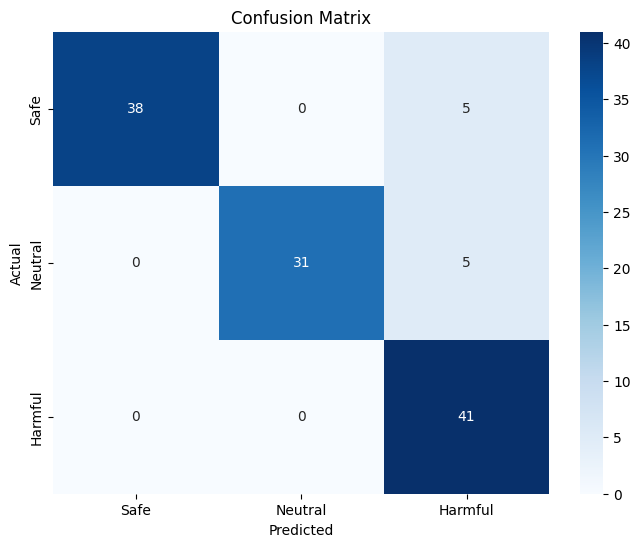

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe', 'Neutral', 'Harmful'],  # Corrected labels
            yticklabels=['Safe', 'Neutral', 'Harmful'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Feature importance extraction
if hasattr(tfidf, 'get_feature_names_out'):
  feature_names = tfidf.get_feature_names_out()

else:
  feature_names = [f'Feature_{i}' for i in range(len(rf_classifier.feature_importances_))]

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_classifier.feature_importances_
})

In [ ]:
# Select top 20 important features
top_features = feature_importance.sort_values('importance', ascending=False).head(20)

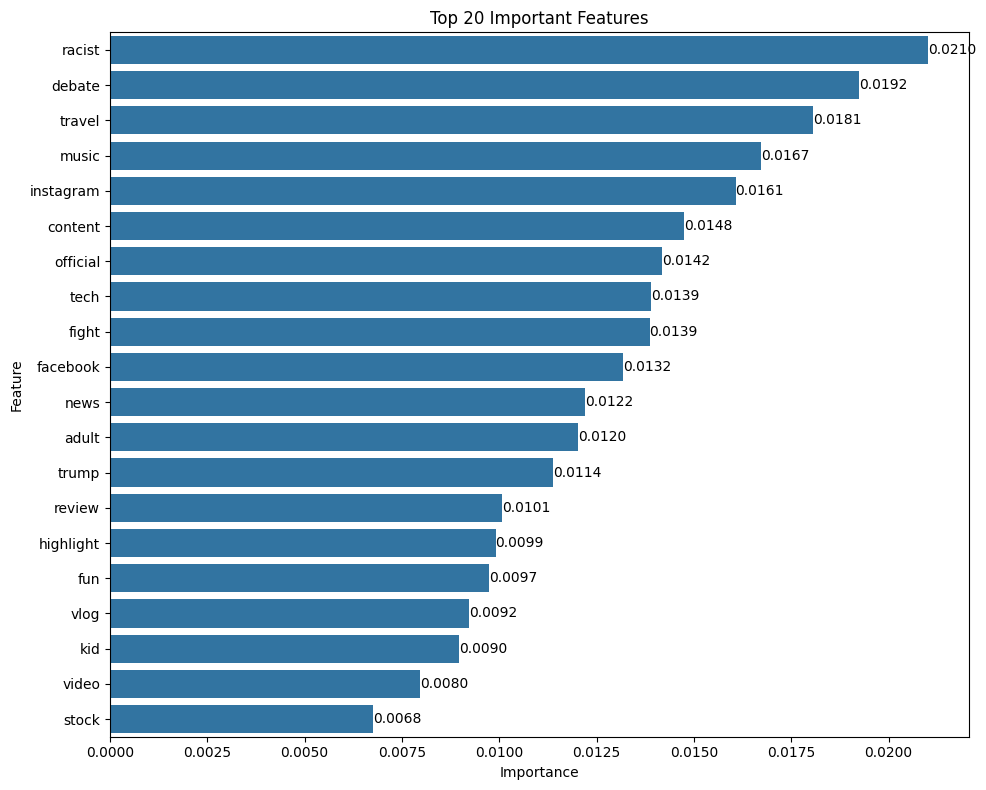

In [ ]:
# Plot top features
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 20 Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
# Annotate bars with importance values
for p in ax.patches:
    ax.annotate(f'{p.get_width():.4f}', (p.get_width(), p.get_y() + p.get_height()/2),
                ha='left', va='center', fontsize=10, color='black')
plt.tight_layout()
plt.show()

In [ ]:
# Saving to a .csv file

In [ ]:
# Try to save the model, vectorizer, and dataset
import pickle
try:
    with open('youtube_content_classifier.pkl', 'wb') as model_file:
        pickle.dump(rf_classifier, model_file)

    with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
        pickle.dump(tfidf, vectorizer_file)

    df.to_csv('youtube_metadata.csv', index=False)
    print(" Analysis complete. Model and data saved successfully.")

except Exception as e:
    print(f" Error saving files: {e}")


 Analysis complete. Model and data saved successfully.


In [ ]:
metadata_csv = pd.read_csv('youtube_metadata.csv')
metadata_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   video_id               600 non-null    object
 1   title                  600 non-null    object
 2   description            530 non-null    object
 3   channel_title          600 non-null    object
 4   publish_date           600 non-null    object
 5   view_count             600 non-null    int64 
 6   like_count             600 non-null    int64 
 7   category               600 non-null    object
 8   processed_title        600 non-null    object
 9   processed_description  528 non-null    object
 10  combined_text          600 non-null    object
 11  category_label         600 non-null    int64 
dtypes: int64(3), object(9)
memory usage: 56.4+ KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   video_id               600 non-null    object
 1   title                  600 non-null    object
 2   description            600 non-null    object
 3   channel_title          600 non-null    object
 4   publish_date           600 non-null    object
 5   view_count             600 non-null    object
 6   like_count             600 non-null    object
 7   category               600 non-null    object
 8   processed_title        600 non-null    object
 9   processed_description  600 non-null    object
 10  combined_text          600 non-null    object
 11  category_label         600 non-null    int64 
dtypes: int64(1), object(11)
memory usage: 56.4+ KB


In [ ]:
# Sri Rama Jayam
# Training the NLP Model (using LSTM)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
X = df['combined_text']
y = df['category_label']

y = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text

max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [ ]:
import pickle

# Save tokenizer to a file
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer saved successfully!")

Tokenizer saved successfully!


In [ ]:
# Build the LSTM model
model = Sequential([
    Embedding(max_words, 128),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) #Using categorical_crossentropy as loss

In [ ]:
# Train the model
history_content_moderation = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.3613 - loss: 1.0962 - val_accuracy: 0.6771 - val_loss: 1.0668
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6729 - loss: 1.0440 - val_accuracy: 0.7083 - val_loss: 0.9430
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7088 - loss: 0.8383 - val_accuracy: 0.8229 - val_loss: 0.6850
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8931 - loss: 0.5110 - val_accuracy: 0.8333 - val_loss: 0.4316
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9324 - loss: 0.2746 - val_accuracy: 0.8125 - val_loss: 0.5031
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9245 - loss: 0.2488 - val_accuracy: 0.8333 - val_loss: 0.3809
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9736 - loss: 0.1381 - val_accuracy: 0.8542 - val_loss: 0.4207
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9626 - loss: 0.1295 - val_accuracy: 0.8333 - 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.8500


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


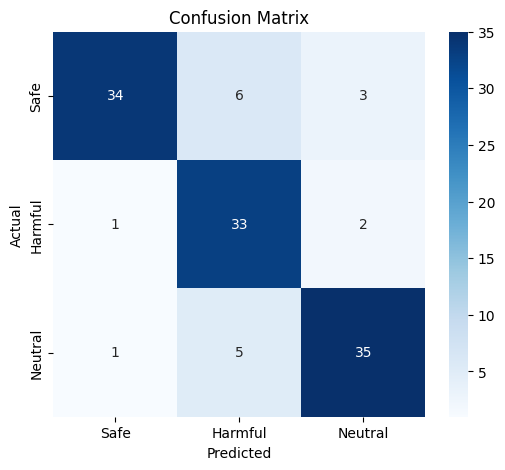

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predicted labels
predictions = model.predict(X_test_pad)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe', 'Harmful', 'Neutral'], yticklabels=['Safe', 'Harmful', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


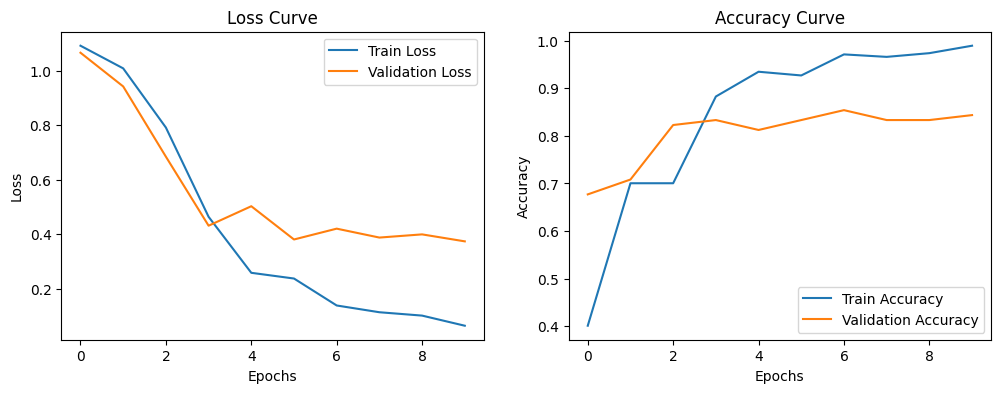

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history
history = history_content_moderation.history

# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


In [ ]:
import numpy as np

# Get predictions
y_pred_probs = model.predict(X_test_pad)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test back to class labels


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Harmful', 'Neutral', 'Safe'])
print(report)

              precision    recall  f1-score   support

     Harmful       0.94      0.79      0.86        43
     Neutral       0.75      0.92      0.82        36
        Safe       0.88      0.85      0.86        41

    accuracy                           0.85       120
   macro avg       0.86      0.85      0.85       120
weighted avg       0.86      0.85      0.85       120



In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 200, 128)              │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (32, 200, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (32, 32)                    │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,032,395 (15.38 MB)

 Trainable params: 1,344,131 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,688,264 (10.25 MB)

In [ ]:
# Save your model
model.save("youtube_moderation_model.keras")

## **Fine-Tuning the Model**  

The model currently achieves an **overall accuracy of 85%**. To further enhance its performance, we will explore various fine-tuning techniques to improve accuracy and classification effectiveness.


In [ ]:
# Fine tuning the model
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train.argmax(axis=1)),  # Convert one-hot encoding to class labels
    y=y_train.argmax(axis=1)
)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weight_dict)

# Train with class weights
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,  # Apply class weights
    verbose=1
)


Class Weights: {0: np.float64(1.019108280254777), 1: np.float64(0.975609756097561), 2: np.float64(1.0062893081761006)}
Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9920 - loss: 0.0484 - val_accuracy: 0.8646 - val_loss: 0.3232
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9933 - loss: 0.0372 - val_accuracy: 0.8750 - val_loss: 0.3047
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9986 - loss: 0.0234 - val_accuracy: 0.9375 - val_loss: 0.1908
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9973 - loss: 0.0226 - val_accuracy: 0.9583 - val_loss: 0.1545
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9973 - loss: 0.0263 - val_accuracy: 0.9479 - val_loss: 0.1963
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9967 - loss: 0.0231 - val_accuracy: 0.8958 - val_loss: 0.2544
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9989 - loss: 0.0136 - val_accuracy: 0.9062 - val_loss:

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.8250


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


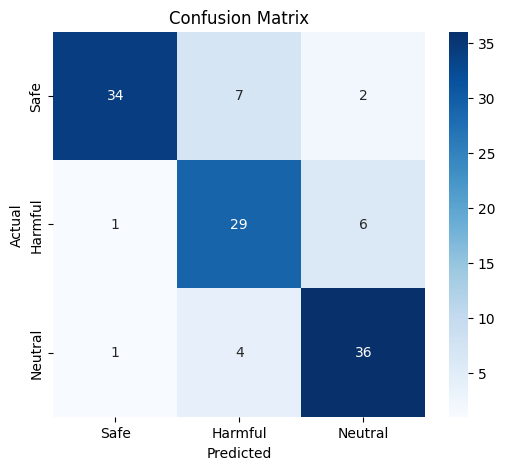

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predicted labels
predictions = model.predict(X_test_pad)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe', 'Harmful', 'Neutral'], yticklabels=['Safe', 'Harmful', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


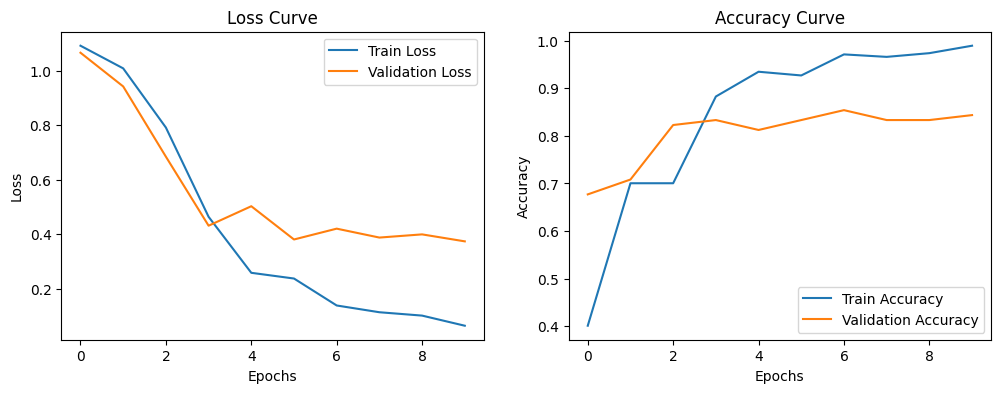

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history
history = history_content_moderation.history

# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


In [ ]:
import numpy as np

# Get predictions
y_pred_probs = model.predict(X_test_pad)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test back to class labels


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Harmful', 'Neutral', 'Safe'])
print(report)

              precision    recall  f1-score   support

     Harmful       0.94      0.79      0.86        43
     Neutral       0.72      0.81      0.76        36
        Safe       0.82      0.88      0.85        41

    accuracy                           0.82       120
   macro avg       0.83      0.82      0.82       120
weighted avg       0.84      0.82      0.83       120



In [ ]:
print("Sri Rama Jayam")

Sri Rama Jayam
